# Comparison of the molecular domain between cell lines and tumors for breast cancer
This notebook supports the second figure. It takes data from cell lines, PDXs and tumors, compute the <em>domain-specific factors</em> and compare them using the <em>cosine similarity matrix</em>.
<br/>
Finally, tumor data is projected on each of these domain-specific factors and variance explained is computed to see how tumor variance is supported.
<br/>
This figure also supports Fig Supp 1.

In [1]:
# Tissue to consider
tumor_type = 'Breast'
cell_line_type = 'BRCA'
pdx_type = 'BRCA'

# Normalization parameters
normalization = 'TMM'
transformation = 'log'
mean_center = True
std_unit = False
protein_coding_only = True

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.decomposition import PCA, FastICA, SparsePCA
from sklearn.externals.joblib import Parallel, delayed
import matplotlib.cm as cm
plt.style.use('ggplot')


#Import src implementations
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from data_reader.read_data import read_data
from normalization_methods.feature_engineering import feature_engineering

## Import data

In [5]:
# Import tumor + cell line data (count data)
x_target, x_source, g, _, _ = read_data('cell_line',
                                        'tumor',
                                        'count',
                                        cell_line_type,
                                        tumor_type,
                                        remove_mytochondria=False)
cl_vs_t = {'source':x_source,
          'target':x_target}
cl_vs_t_genes = g
del g, x_target, x_source

print('Cell lines vs Tumors data imported')


# Import tumor + pdx data (FPKM)
x_target, x_source, g, _, _ = read_data('pdx',
                                        'tumor',
                                        'fpkm',
                                        pdx_type,
                                        tumor_type,
                                        remove_mytochondria=False)
pdx_vs_t = {'source':x_source,
          'target':x_target}
pdx_vs_t_genes = g
del g, x_target, x_source

print('PDX vs tumors data imported')

# Import PDX + cell-line data (FPKM)
x_target, x_source, g, _, _ = read_data('cell_line',
                                        'pdx',
                                        'fpkm',
                                        cell_line_type,
                                        pdx_type,
                                        remove_mytochondria=False)
cl_vs_pdx = {'source':x_source,
              'target':x_target}
cl_vs_pdx_genes = g
del g, x_target, x_source

print('Cell lines vs PDX data imported')

Cell lines vs Tumors data imported
PDX vs tumors data imported
Cell lines vs PDX data imported


In [6]:
# Normalization & Transformation for RNA-Seq data
for e in [cl_vs_t, pdx_vs_t, cl_vs_pdx]:
    e['source'] = feature_engineering(e['source'], normalization, transformation, mean_center, std_unit)
    e['target'] = feature_engineering(e['target'], normalization, transformation, mean_center, std_unit)

## Cosines similarity computation
Computes and plot the cosines similarity and plot it. Also breaks down the results per PC to show the overlap.

In [7]:
number_components = 20

def compute_components_PCA(x):
    pca_instance = PCA(number_components)
    pca_instance.fit(x)
    
    return pca_instance.components_

def compute_components_Sparse_PCA(x):
    pca_instance = SparsePCA(number_components, verbose=10)
    pca_instance.fit(x)
    
    print('computed')
    return pca_instance.components_

def compute_components_ICA(x):
    ica_instance = Fast(number_components, n_jobs=3)
    ica_instance.fit(x)
    
    print('COMPUTED')
    return orth(ica_instance.mixing_).transpose()

def compute_cosine_similarity(data, dim_red_method):
    source_components = dim_red_method(data['source'])
    target_components = dim_red_method(data['target'])
    
    components = {
        'source':source_components,
        'target':target_components
    }
    
    return source_components.dot(target_components.transpose()), components

compute_components = compute_components_PCA

cl_vs_t_cosine_similarity, cl_vs_t_components = compute_cosine_similarity(cl_vs_t, compute_components)
pdx_vs_t_cosine_similarity, pdx_vs_t_components = compute_cosine_similarity(pdx_vs_t, compute_components)
cl_vs_pdx_cosine_similarity, cl_vs_pdx_components = compute_cosine_similarity(cl_vs_pdx, compute_components)

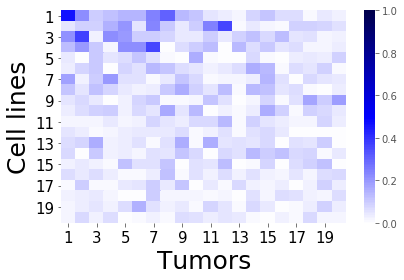

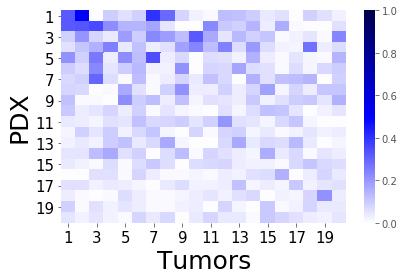

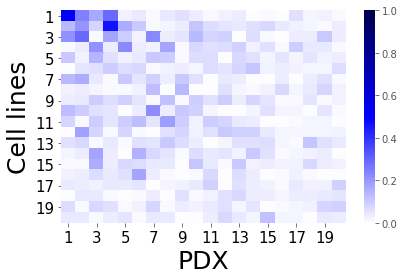

In [8]:
# Plot cosines similarity between cell lines and tumors
sns.heatmap(np.abs(cl_vs_t_cosine_similarity), cmap='seismic_r',\
                center=0, vmax=1., vmin=0)

plt.ylabel('Cell lines', fontsize=25, color='black')
plt.xlabel('Tumors', fontsize=25, color='black')
plt.xticks(np.arange(.5,number_components,2), range(1,number_components+1,2), fontsize=15, color='black')
plt.yticks(np.arange(.5,number_components,2), range(1,number_components+1,2), fontsize=15, color='black')
plt.tight_layout()
if tumor_type == 'Breast':
    plt.savefig('./figures/fig2_cosines_similarity_cell_lines_tumors_RNAseq_%s_%s.png'%(tumor_type, cell_line_type.replace('/','')),\
                dpi=300)
else:
    plt.savefig('./figures/supp_fig2_cosines_similarity_cell_lines_tumors_RNAseq_%s_%s.png'%(tumor_type, cell_line_type.replace('/','')),\
               dpi=300)
plt.show()


# Plot cosines similarity between pdx and tumors
sns.heatmap(np.abs(pdx_vs_t_cosine_similarity), cmap='seismic_r',\
                center=0, vmax=1., vmin=0)

plt.ylabel('PDX', fontsize=25, color='black')
plt.xlabel('Tumors', fontsize=25, color='black')
plt.xticks(np.arange(.5,number_components,2), range(1,number_components+1,2), fontsize=15, color='black')
plt.yticks(np.arange(.5,number_components,2), range(1,number_components+1,2), fontsize=15, color='black')
plt.tight_layout()
if tumor_type == 'Breast':
    plt.savefig('./figures/fig2_cosines_similarity_pdx_tumors_RNAseq_%s_%s.png'%(tumor_type, pdx_type.replace('/','')),\
               dpi=300)
else:
    plt.savefig('./figures/supp_fig2_cosines_similarity_pdx_tumors_RNAseq_%s_%s.png'%(tumor_type, pdx_type.replace('/','')),\
               dpi=300)
plt.show()

# Plot cosines similarity between cell lines and pdx
sns.heatmap(np.abs(cl_vs_pdx_cosine_similarity), cmap='seismic_r',\
                center=0, vmax=1., vmin=0)

plt.ylabel('Cell lines', fontsize=25, color='black')
plt.xlabel('PDX', fontsize=25, color='black')
plt.xticks(np.arange(.5,number_components,2), range(1,number_components+1,2), fontsize=15, color='black')
plt.yticks(np.arange(.5,number_components,2), range(1,number_components+1,2), fontsize=15, color='black')
plt.tight_layout()
if tumor_type == 'Breast':
    plt.savefig('./figures/fig2_cosines_similarity_cell_lines_pdx_RNAseq_%s_%s.png'%(tumor_type, pdx_type.replace('/','')),\
               dpi=300)
else:
    plt.savefig('./figures/supp_fig2_cosines_similarity_cell_lines_pdx_RNAseq_%s_%s.png'%(tumor_type, pdx_type.replace('/','')),\
               dpi=300)
plt.show()

## Variance explained

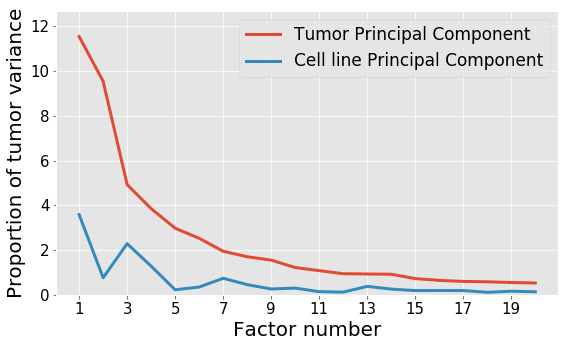

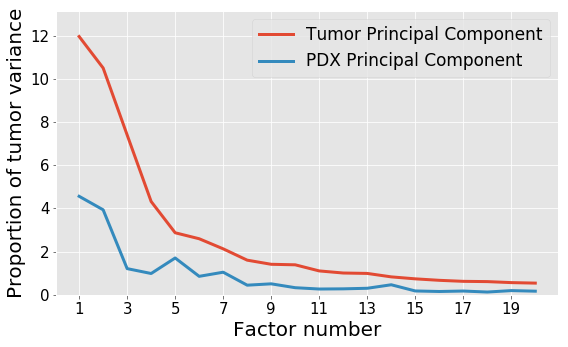

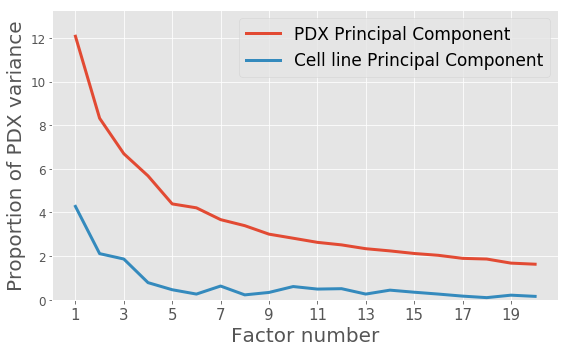

In [9]:
# Tumor variance explained by cell lines
def target_variance_projected(data, components):
    target_projected_variance = np.var(data['target'].dot(components['target'].transpose()),0)
    source_projected_variance = np.var(data['target'].dot(components['source'].transpose()),0)
    
    target_total_variance = np.sum(np.var(data['target'], 0))
    
    return {
        'source': source_projected_variance / target_total_variance,
        'target': target_projected_variance / target_total_variance
    }

# Compute target projected variance
cl_vs_t_variance = target_variance_projected(cl_vs_t, cl_vs_t_components)
cl_vs_pdx_variance = target_variance_projected(cl_vs_pdx, cl_vs_pdx_components)
pdx_vs_t_variance = target_variance_projected(pdx_vs_t, pdx_vs_t_components)

#####
# Cell lines vs Tumors
#####
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, number_components+1), cl_vs_t_variance['target'],\
         label='Tumor Principal Component', linewidth=3)
plt.plot(np.arange(1, number_components+1), cl_vs_t_variance['source'],\
         label='Cell line Principal Component', linewidth=3)

plt.xticks(np.arange(1, number_components+1, 2), fontsize=15, color='black')
max_var = cl_vs_t_variance['target'][0]
plt.ylim(0,1.1*max_var)
plt.yticks(np.arange(0, 1.1*max_var,0.02), (np.arange(0, 1.1*max_var,0.02)*100).astype(int), fontsize=15, color='black')
del max_var
plt.xlabel('Factor number', fontsize=20, color='black')
plt.ylabel('Proportion of tumor variance', fontsize=20, color='black')
plt.legend(fontsize=17)
plt.tight_layout()
if tumor_type == 'Breast':
    plt.savefig('./figures/fig2_variance_explained_cl_vs_t_%s_%s.png'%(tumor_type, cell_line_type.replace('/','')),\
               dpi=300)
else:
    plt.savefig('./figures/supp_fig2_variance_explained_cl_vs_t_%s_%s.png'%(tumor_type, cell_line_type.replace('/','')),\
               dpi=300)
plt.show()

#####
# PDX vs Tumors
#####
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, number_components+1), pdx_vs_t_variance['target'],\
         label='Tumor Principal Component', linewidth=3)
plt.plot(np.arange(1, number_components+1), pdx_vs_t_variance['source'],\
         label='PDX Principal Component', linewidth=3)

plt.xticks(np.arange(1, number_components+1, 2), fontsize=15, color='black')
max_var = pdx_vs_t_variance['target'][0]
plt.ylim(0,1.1*max_var)
plt.yticks(np.arange(0, 1.1*max_var,0.02), (np.arange(0, 1.1*max_var,0.02)*100).astype(int), fontsize=15, color='black')
del max_var
plt.xlabel('Factor number', fontsize=20, color='black')
plt.ylabel('Proportion of tumor variance', fontsize=20, color='black')
plt.legend(fontsize=17)
plt.tight_layout()
if tumor_type == 'Breast':
    plt.savefig('./figures/fig2_variance_explained_pdx_vs_t_%s_%s.png'%(tumor_type, pdx_type), dpi=300)
else:
    plt.savefig('./figures/supp_fig2_variance_explained_pdx_vs_t_%s_%s.png'%(tumor_type, pdx_type), dpi=300)
plt.show()

#####
# Cell lines vs PDX
#####
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, number_components+1), cl_vs_pdx_variance['target'],\
         label='PDX Principal Component', linewidth=3)
plt.plot(np.arange(1, number_components+1), cl_vs_pdx_variance['source'],\
         label='Cell line Principal Component', linewidth=3)

plt.xticks(np.arange(1, number_components+1, 2), fontsize=15)
max_var = cl_vs_pdx_variance['target'][0]
plt.ylim(0,1.1*max_var)
plt.yticks(np.arange(0, 1.1*max_var,0.02), (np.arange(0, 1.1*max_var,0.02)*100).astype(int), fontsize=12)
plt.xlabel('Factor number', fontsize=20)
plt.ylabel('Proportion of PDX variance', fontsize=20)
plt.legend(fontsize=17)
plt.tight_layout()
if tumor_type == 'Breast':
    plt.savefig('./figures/fig2_variance_explained_cl_vs_t_%s_%s.png'%(tumor_type, pdx_type), dpi=300)
else:
    plt.savefig('./figures/supp_fig2_variance_explained_cl_vs_t_%s_%s.png'%(tumor_type, pdx_type), dpi=300)
plt.show()

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of  10 | elapsed:    9.1s remaining:   21.2s
[Parallel(n_jobs=5)]: Done   5 out of  10 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:   14.0s remaining:    6.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:   14.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of  10 | elapsed:    5.4s remaining:   12.6s
[Parallel(n_jobs=5)]: Done   5 out of  10 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:   10.5s remaining:    4.5s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:   10.6s finished


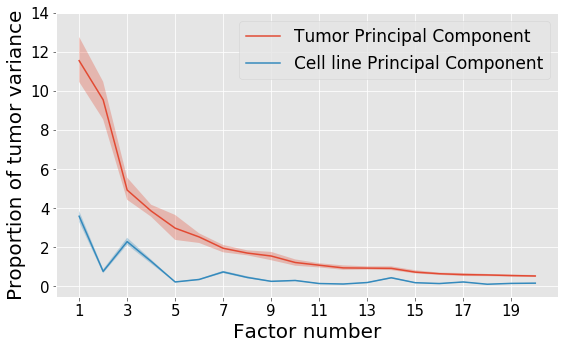

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of  10 | elapsed:    4.6s remaining:   10.7s
[Parallel(n_jobs=5)]: Done   5 out of  10 | elapsed:    4.6s remaining:    4.6s
[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    9.9s remaining:    4.2s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of  10 | elapsed:    5.3s remaining:   12.4s
[Parallel(n_jobs=5)]: Done   5 out of  10 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:   10.1s remaining:    4.3s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:   10.4s finished


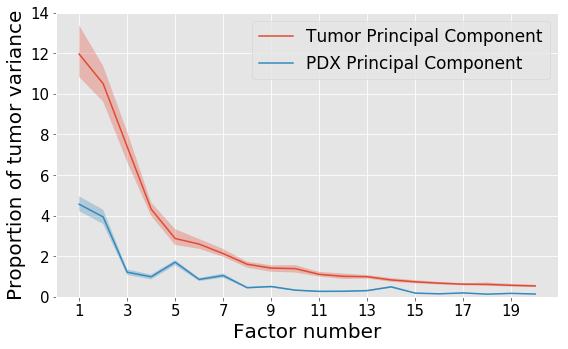

In [13]:
## Bootstrap analysis for variance

n_jobs = 5

def bootstrap_projected_variance(data_var, components, n=1):
    np.random.seed()
    bootstrapped_variance = []
    for _ in range(n):
        e = np.random.choice(range(data_var.shape[0]), size=data_var.shape[0], replace=True)
        bootstrapped_variance.append(np.var(data_var[e].dot(components.transpose()),0))
        
    return bootstrapped_variance

#####
# CL vs Tumor
#####

target = cl_vs_t['target']
source = cl_vs_t['source']

# Compute components
target_components = compute_components(target)
source_components = compute_components(source)

# Bootstrap target data and project it onto the different components.
n_bootstrap = 100
size_batch = 10
bootstrapped_target_variance = Parallel(n_jobs=n_jobs, verbose=10)\
                                (delayed(bootstrap_projected_variance)(target, target_components, size_batch)
                                for _ in range(int(n_bootstrap/size_batch)))
bootstrapped_target_variance = np.concatenate(bootstrapped_target_variance)
bootstrapped_source_variance = Parallel(n_jobs=n_jobs, verbose=10)\
                                (delayed(bootstrap_projected_variance)(target, source_components, size_batch)
                                for _ in range(int(n_bootstrap/size_batch)))
bootstrapped_source_variance = np.concatenate(bootstrapped_source_variance)

# Compute variance projected
target_proj_variance = np.var(target.dot(target_components.transpose()), 0)
source_proj_variance = np.var(target.dot(source_components.transpose()), 0)
target_var = np.sum(np.var(target,0))

source_proj_variance /= target_var
target_proj_variance /= target_var
bootstrapped_target_variance /= target_var
bootstrapped_source_variance /= target_var

# Plot figure
plt.figure(figsize=(8,5))
plt.plot(range(1, target_proj_variance.shape[0]+1), target_proj_variance, label='Tumor Principal Component')
plt.fill_between(range(1,target_proj_variance.shape[0]+1),
        np.percentile(bootstrapped_target_variance, 1, axis=0),
        np.percentile(bootstrapped_target_variance, 99, axis=0),
        alpha=0.3)
plt.plot(range(1, source_proj_variance.shape[0]+1),source_proj_variance, label='Cell line Principal Component')
plt.fill_between(range(1, source_proj_variance.shape[0]+1),
        np.percentile(bootstrapped_source_variance, 1, axis=0),
        np.percentile(bootstrapped_source_variance, 99, axis=0),
        alpha=0.3)

plt.xticks(np.arange(1, number_components+1, 2), fontsize=15, color='black')
max_var = np.percentile(bootstrapped_target_variance, 99, axis=0)[0]
plt.yticks(np.arange(0, 1.1*max_var,0.02), (np.arange(0, 1.1*max_var,0.02)*100).astype(int), fontsize=15, color='black')
del max_var
plt.xlabel('Factor number', fontsize=20, color='black')
plt.ylabel('Proportion of tumor variance', fontsize=20, color='black')
plt.legend(fontsize=17)
plt.tight_layout()
if tumor_type == 'Breast':
    plt.savefig('./figures/fig2_variance_explained_bootstrapped_cl_vs_t_%s_%s_boot_%s.png'%(tumor_type,
                                                                                            cell_line_type.replace('/',''),
                                                                                           n_bootstrap),\
               dpi=300)
plt.show()


#####
# PDX vs Tumors
#####
target = pdx_vs_t['target']
source = pdx_vs_t['source']

target_components = compute_components(target)
source_components = compute_components(source)

n_bootstrap = 100
size_batch = 10
bootstrapped_target_variance = Parallel(n_jobs=n_jobs, verbose=10)\
                                (delayed(bootstrap_projected_variance)(target, target_components, size_batch)
                                for _ in range(int(n_bootstrap/size_batch)))
bootstrapped_target_variance = np.concatenate(bootstrapped_target_variance)
bootstrapped_source_variance = Parallel(n_jobs=n_jobs, verbose=10)\
                                (delayed(bootstrap_projected_variance)(target, source_components, size_batch)
                                for _ in range(int(n_bootstrap/size_batch)))
bootstrapped_source_variance = np.concatenate(bootstrapped_source_variance)

target_proj_variance = np.var(target.dot(target_components.transpose()), 0)
source_proj_variance = np.var(target.dot(source_components.transpose()), 0)
target_var = np.sum(np.var(target,0))

source_proj_variance /= target_var
target_proj_variance /= target_var
bootstrapped_target_variance /= target_var
bootstrapped_source_variance /= target_var

plt.figure(figsize=(8,5))
plt.plot(range(1, target_proj_variance.shape[0]+1), target_proj_variance, label='Tumor Principal Component')
plt.fill_between(range(1,target_proj_variance.shape[0]+1),
        np.percentile(bootstrapped_target_variance, 1, axis=0),
        np.percentile(bootstrapped_target_variance, 99, axis=0),
        alpha=0.3)
plt.plot(range(1, source_proj_variance.shape[0]+1),source_proj_variance, label='PDX Principal Component')
plt.fill_between(range(1, source_proj_variance.shape[0]+1),
        np.percentile(bootstrapped_source_variance, 1, axis=0),
        np.percentile(bootstrapped_source_variance, 99, axis=0),
        alpha=0.3)

plt.xticks(np.arange(1, number_components+1, 2), fontsize=15, color='black')
max_var = np.percentile(bootstrapped_target_variance, 99, axis=0)[0]
plt.ylim(0,max_var)
plt.yticks(np.arange(0, 1.1*max_var,0.02), (np.arange(0, 1.1*max_var,0.02)*100).astype(int), fontsize=15, color='black')
del max_var
plt.xlabel('Factor number', fontsize=20, color='black')
plt.ylabel('Proportion of tumor variance', fontsize=20, color='black')
plt.legend(fontsize=17)
plt.tight_layout()
if tumor_type == 'Breast':
    plt.savefig('./figures/fig2_variance_explained_bootstrapped_pdx_vs_t_%s_%s_boot_%s.png'%(tumor_type,
                                                                                             pdx_type,
                                                                                            n_bootstrap),\
               dpi=300)
plt.show()